<a href="https://colab.research.google.com/github/Emsh1379/Stock_prediction/blob/main/Stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install yfinance
!pip install keras-tuner

In [4]:
!rm -rf my_dir


In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [6]:
import yfinance as yf

In [7]:
ms = yf.download("GOOG",
            start = "2012-01-01",
            end ="2021-12-31",
            progress = False )
df = ms[["Adj Close","Open","Close","High","Low"]].round(3)
df['Date']= df.index
df.head()

,Adj Close,Open,Close,High,Low,Date
Date,,,,,,
2012-01-03,16.573,16.263,16.573,16.641,16.248,2012-01-03
2012-01-04,16.645,16.564,16.645,16.694,16.454,2012-01-04
2012-01-05,16.414,16.491,16.414,16.537,16.344,2012-01-05
2012-01-06,16.190,16.417,16.190,16.438,16.184,2012-01-06
2012-01-09,15.503,16.102,15.503,16.115,15.473,2012-01-09


<Axes: xlabel='Date'>

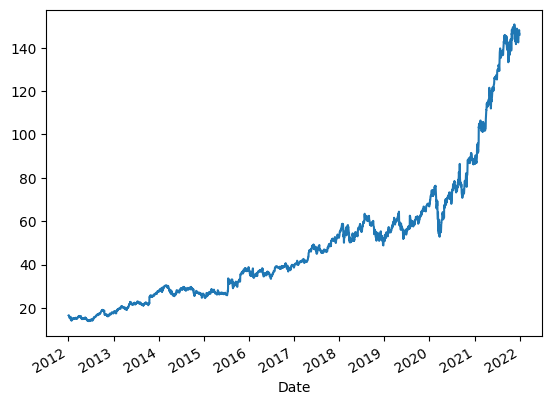

In [8]:
df.Close.plot()

#SVM

R2 score: 0.93471250801891
Mean absolute error: 4.0326415294603


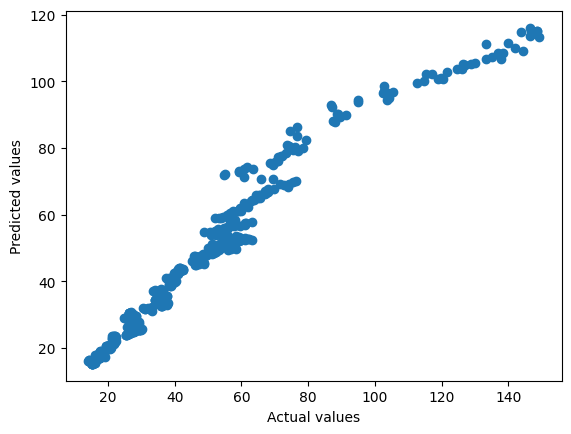

In [9]:
# prompt: build model of svm for date and close values

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
# split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(
    df[['Date']], df['Close'], test_size=0.2, random_state=42)
# fit SVR model on training data
model = SVR()
model.fit(x_train, y_train)
# make predictions on test data
y_pred = model.predict(x_test)
# evaluate model performance
print('R2 score:', model.score(x_test, y_test))
print('Mean absolute error:', np.mean(np.abs(y_test - y_pred)))
# plot predicted vs actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()


<Axes: xlabel='Date'>

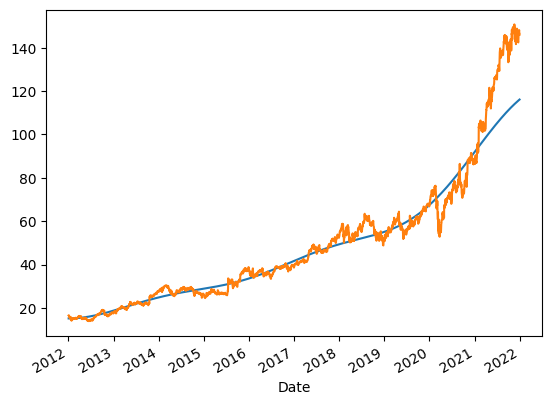

In [10]:
df['Prediction'] = model.predict(df[['Date']])
df.Prediction.plot()
df.Close.plot()


# Train Data and Test Data

In [11]:
# Determin ratio of train to test ratio
ratio = 0.8
split_point = int(df.Close.values.reshape(-1,1).shape[0] * ratio)
train_df = df[:split_point].Close.values.reshape(-1,1)
test_df = df[split_point:].Close.values.reshape(-1,1)


In [12]:
X_train = []
y_train = []
y_steps = 5
X_steps = 10
for i in range(X_steps, len(train_df) - y_steps + 1):
  X_train.append(train_df[i-X_steps:i,0])
  y_train.append(train_df[i:i+y_steps,0])

X = df.Close.values
X = X[len(X)-len(test_df)-X_steps:]
X = X.reshape(-1,1)

X_test = []
y_test = []
for i in range(X_steps, len(test_df) - y_steps + X_steps + 1):
  X_test.append(X[i-X_steps:i,0])
  y_test.append(X[i:i+y_steps,0])






In [13]:
test_df[-15:,0]

array([148.106, 148.675, 146.704, 144.971, 147.368, 144.839, 142.803,
       142.402, 144.221, 146.949, 147.143, 148.064, 146.448, 146.505,
       146.003])

In [14]:
X_test[-1]


array([148.106, 148.675, 146.704, 144.971, 147.368, 144.839, 142.803,
       142.402, 144.221, 146.949])

In [15]:
y_test[-1]


array([147.143, 148.064, 146.448, 146.505, 146.003])

In [16]:
np.array(X_train).shape


(1998, 10)

In [17]:
def ts_data(df,X_steps,y_steps):
  split_point = int(df.Close.values.reshape(-1,1).shape[0] * ratio)
  train_df = df[:split_point].Close.values.reshape(-1,1)
  test_df = df[split_point:].Close.values.reshape(-1,1)

  sc = MinMaxScaler(feature_range=(0,1))
  train_df = sc.fit_transform(train_df)


  X_train = []
  y_train = []
  for i in range(X_steps, len(train_df) - y_steps + 1):
    X_train.append(train_df[i-X_steps:i,0])
    y_train.append(train_df[i:i+y_steps,0])
  X_train = np.array(X_train)
  y_train = np.array(y_train)

  X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)

  X = df.Close.values
  X = X[len(X)-len(test_df)-X_steps:]
  X = X.reshape(-1,1)
  X = sc.transform(X)

  X_test = []
  y_test = []
  for i in range(X_steps, len(test_df) - y_steps + X_steps + 1):
    X_test.append(X[i-X_steps:i,0])
    y_test.append(X[i:i+y_steps,0])
  X_test = np.array(X_test)
  y_test = np.array(y_test)

  X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

  return X_train,y_train,X_test,y_test,sc






# Determine X_steps and y_steps

In [18]:
X_steps,y_steps = 6,2

In [19]:
X_train,y_train,X_test,y_test,sc = ts_data(df,X_steps,y_steps)



In [20]:
X_train.shape



(2005, 6, 1)

In [21]:
y_train.shape




(2005, 2)

In [22]:
X_test.shape

(503, 6, 1)

In [23]:
y_test.shape



(503, 2)

# Simple RNN-Model

In [24]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [25]:
import keras_tuner
from tensorflow import keras

def build_model(hp):
  model = keras.Sequential()
  for i in range(hp.Int('num_layers', 1, 5)):
    model.add(SimpleRNN(hp.Int('units_' + str(i), 10, 100), return_sequences=True))
  model.add(SimpleRNN(hp.Int('units_' + str(i + 1), 10, 100)))
  model.add(keras.layers.Dense(2, activation='relu'))
  model.compile(optimizer='adam',loss='mean_absolute_error')
  return model


tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    directory='my_dir',
    project_name='simpleRNN_tuning'
    )

In [26]:
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test,y_test))
best_model = tuner.get_best_models()[0]

Trial 20 Complete [00h 00m 22s]
val_loss: 0.30802711844444275

Best val_loss So Far: 0.10116619616746902
Total elapsed time: 00h 08m 09s


In [27]:
simple_rnn_model = best_model

In [29]:
simple_rnn_pred = simple_rnn_model.predict(X_test)
simple_rnn_pred.shape


16/16 [==============================] - 1s 2ms/step


(503, 2)

In [30]:
def prediction_plot(predictions):
  fig , ax = plt.subplots(figsize=(10,5))
  ax.plot(df[split_point:].index[:len(y_test)],
          sc.inverse_transform(y_test[:,0].reshape(-1,1)),label = "Real")
  ax.plot(df[split_point:].index[:len(y_test)],
          sc.inverse_transform(predictions[:,0].reshape(-1,1)),label = "Prediction")

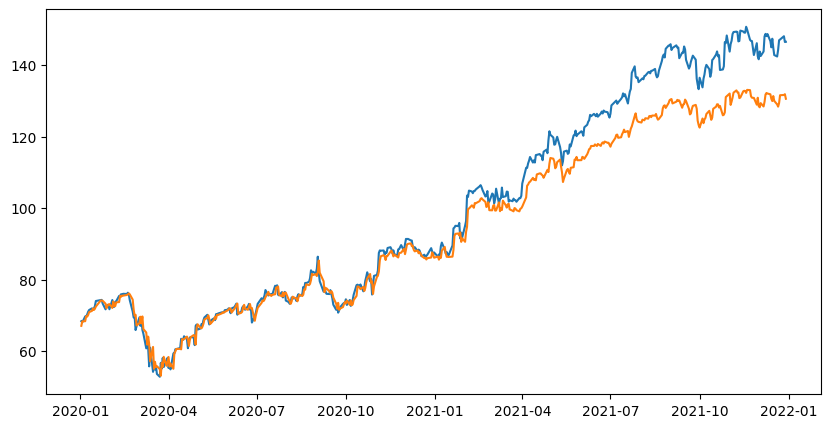

In [31]:
prediction_plot(simple_rnn_pred)



In [32]:
simple_rnn_model.evaluate(X_test,y_test)

16/16 [==============================] - 0s 3ms/step - loss: 0.1012


0.10116619616746902

In [33]:
simple_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 6, 52)             2808      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 90)                12870     
                                                                 
 dense (Dense)               (None, 2)                 182       
                                                                 
Total params: 15860 (61.95 KB)
Trainable params: 15860 (61.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# LSTM

In [34]:
from keras.layers import LSTM

In [35]:
import keras_tuner
from tensorflow import keras

def build_model(hp):
  model = keras.Sequential()
  for i in range(hp.Int('num_layers', 1, 5)):
    model.add(LSTM(hp.Int('units_' + str(i), 10, 100), return_sequences=True))
  model.add(LSTM(hp.Int('units_' + str(i + 1), 10, 100)))
  model.add(keras.layers.Dense(2, activation='relu'))
  model.compile(optimizer='adam',loss='mean_absolute_error')
  return model


tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    directory='my_dir',
    project_name='LSTM_tuning'
    )

In [36]:
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test,y_test))
best_model = tuner.get_best_models()[0]
lstm = best_model

Trial 20 Complete [00h 00m 43s]
val_loss: 1.5834742784500122

Best val_loss So Far: 0.07076679915189743
Total elapsed time: 00h 21m 26s


16/16 [==============================] - 0s 13ms/step


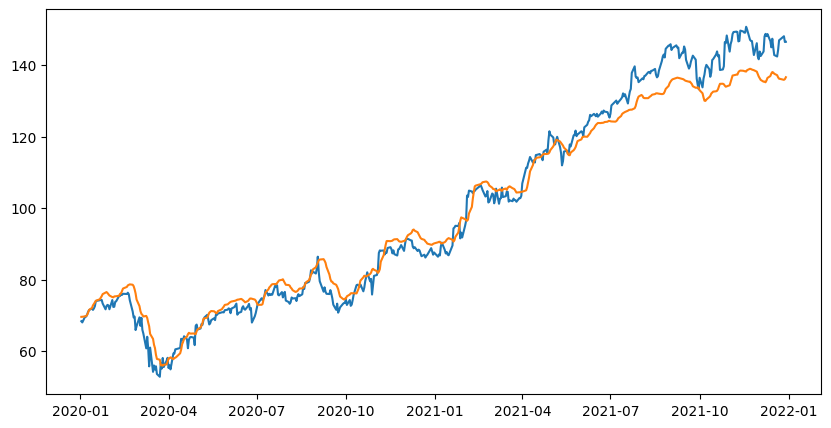

In [41]:
prediction_plot(lstm.predict(X_test))


In [42]:
lstm.evaluate(X_test,y_test)

16/16 [==============================] - 0s 6ms/step - loss: 0.0708


0.07076679915189743

In [43]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 73)             21900     
                                                                 
 lstm_1 (LSTM)               (None, 42)                19488     
                                                                 
 dense (Dense)               (None, 2)                 86        
                                                                 
Total params: 41474 (162.01 KB)
Trainable params: 41474 (162.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# GRU

In [45]:
from keras.layers import GRU
import keras_tuner
from tensorflow import keras

def build_model(hp):
  model = keras.Sequential()
  for i in range(hp.Int('num_layers', 1, 5)):
    model.add(GRU(hp.Int('units_' + str(i), 10, 100), return_sequences=True))
  model.add(GRU(hp.Int('units_' + str(i + 1), 10, 100)))
  model.add(keras.layers.Dense(2, activation='relu'))
  model.compile(optimizer='adam',loss='mean_absolute_error')
  return model


tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    directory='my_dir',
    project_name='GRU_tuning'
    )

In [46]:
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test,y_test))
best_model = tuner.get_best_models()[0]
GRU = best_model

16/16 [==============================] - 5s 10ms/step


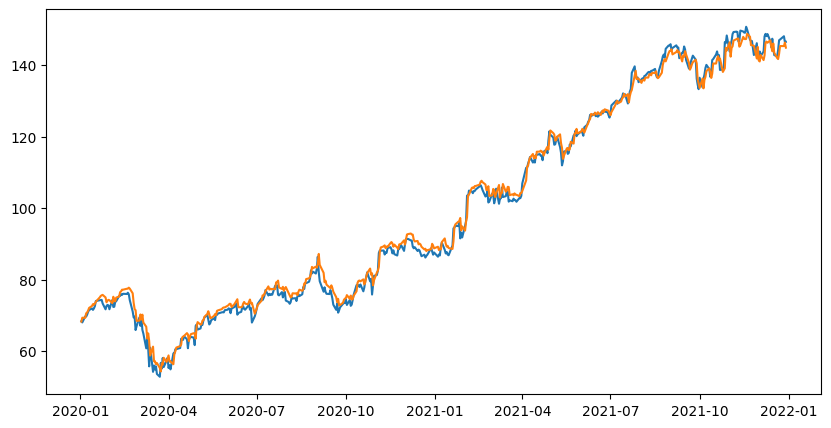

In [47]:
prediction_plot(GRU.predict(X_test))

In [48]:
GRU.evaluate(X_test,y_test)

16/16 [==============================] - 1s 7ms/step - loss: 0.0348


0.03482839837670326

In [50]:
GRU.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 6, 70)             15330     
                                                                 
 gru_1 (GRU)                 (None, 89)                42987     
                                                                 
 dense (Dense)               (None, 2)                 180       
                                                                 
Total params: 58497 (228.50 KB)
Trainable params: 58497 (228.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Combimition of LSTM and GRU

In [87]:
# prompt: delete LSTM_GRU_tuning

!rm -rf my_dir/LSTM_GRU_tuning


In [88]:
from keras.layers import GRU
import keras_tuner
from tensorflow import keras

def build_model(hp):
  model = keras.Sequential()
  for i in range(hp.Int('num_layers', 1, 5)):
    model.add(GRU(hp.Int('units_' + str(i), 10, 100), return_sequences=True))
    model.add(LSTM(hp.Int('units_' + str(i+1), 10, 100), return_sequences=True))
  model.add(GRU(hp.Int('units_' + str(i+2), 10, 100)))
  model.add(keras.layers.Dense(2, activation='relu'))
  model.compile(optimizer='adam',loss='mean_absolute_error')
  return model


In [89]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    directory='my_dir',
    project_name='LSTM_GRU_tuning'
    )

In [90]:
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test,y_test))
best_model = tuner.get_best_models()[0]
LSTM_GRU = best_model


Trial 20 Complete [00h 01m 52s]
val_loss: 0.2709740996360779

Best val_loss So Far: 0.06575855612754822
Total elapsed time: 00h 27m 38s


16/16 [==============================] - 3s 5ms/step


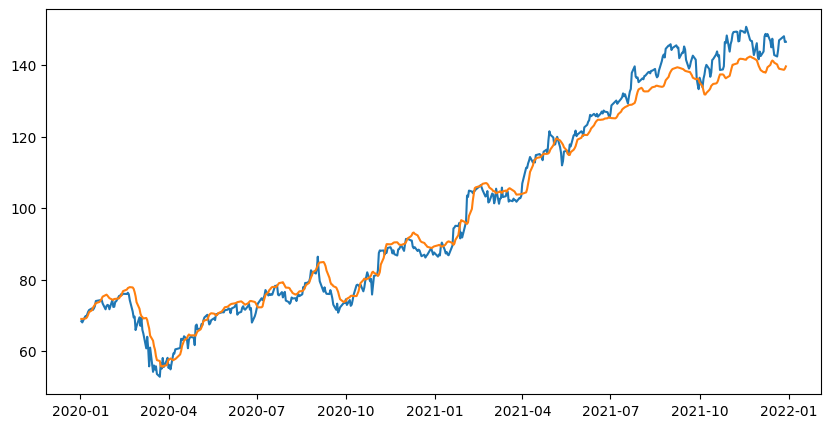

In [91]:
prediction_plot(LSTM_GRU.predict(X_test))

In [92]:
LSTM_GRU.evaluate(X_test,y_test)

16/16 [==============================] - 1s 6ms/step - loss: 0.0658


0.06575855612754822

In [93]:
LSTM_GRU.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 6, 48)             7344      
                                                                 
 lstm (LSTM)                 (None, 6, 93)             52824     
                                                                 
 gru_1 (GRU)                 (None, 77)                39732     
                                                                 
 dense (Dense)               (None, 2)                 156       
                                                                 
Total params: 100056 (390.84 KB)
Trainable params: 100056 (390.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
